<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/8-Generative/dcgan28own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to Doodle

In [ ]:
from IPython.display import display, Image

display(Image(filename="dcgandoodle.gif"))

DCGAN   iki parçalı bir sistemdir. Generator ve Discriminator eğitilir. Böylece amaca uygun bir görüntü oluşturmaya çalışan Generator ve onu yakalmaaya çalışan Discriminator oluşur. Ne zaman discriminator kandırlırsa o zaman sonuç verilir bu yüzden adverserial sayılır.

### Setup


Tensorflow ve diğer gereksinimler

In [1]:
# Bu sonrasında şov amaçlı ara parçaları görmek için epoch sonuçlarından gif yapacağız.
!pip install imageio -q
!pip install git+https://github.com/tensorflow/docs -q

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython import display
tf.__version__

'2.18.0'

### Load and prepare the dataset




Eğer kendi datasetinde çalışmak istersen

In [ ]:
!wget -q  https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/8-Generative/doodles28.zip

In [ ]:
!unzip -qq doodle28.zip

In [3]:
!wget -q  https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/8-Generative/doodlemega.zip

In [6]:
!unzip -qq doodlemega.zip

In [7]:
##set your data size input
img_size=28

In [9]:
# Dataset yükleme fonksiyonu
def load_custom_images(image_dir, img_size=(img_size, img_size)):
    image_paths = glob.glob(image_dir + "/*.png")  # Adjust extension if needed
    images = [img_to_array(load_img(img, color_mode="grayscale", target_size=img_size)) for img in image_paths]
    images = np.array(images).astype("float32") / 127.5 - 1  # Normalize to [-1, 1]
    return images

# Replace dataset loading
image_dir = "doodlemega"
train_images = load_custom_images(image_dir)

# Ensure correct shape
train_images = train_images.reshape(train_images.shape[0], img_size, img_size, 1)

# Create TensorFlow dataset
BUFFER_SIZE = len(train_images) # kaç adet görsel var
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


print(f"Loaded {train_images.shape[0]} images with shape {train_images.shape[1:]}")


Loaded 84588 images with shape (28, 28, 1)


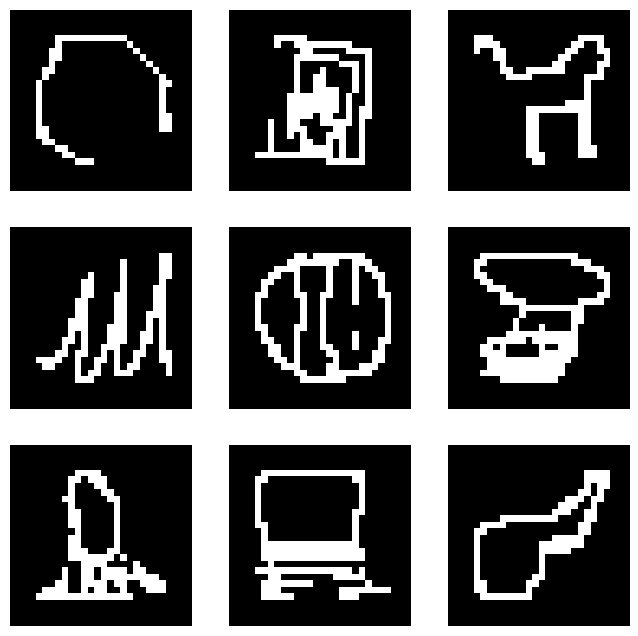

In [10]:
# Get a batch of images
sample_batch = next(iter(train_dataset))

# Display some images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # Convert from [-1, 1] to [0, 1] for proper display
    plt.imshow((sample_batch[i].numpy() + 1) * 0.5, cmap='gray')  # Display as grayscale
    plt.axis("off")

plt.show()

## Create the models

Generator ve discriminator [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model) Kullanır.

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


Use the (as yet untrained) generator to create an image.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


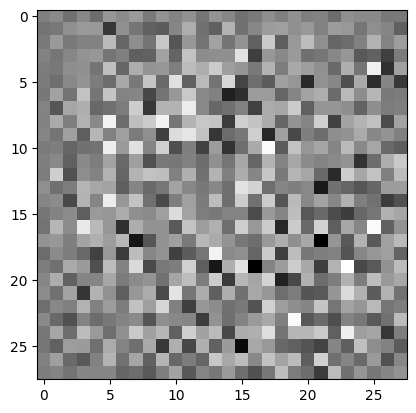

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

Discriminator CNN mantığı ile çalışsan bir classification yapısıdır.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
generated_image = generator(tf.random.normal([1, 100]), training=False)
print(generated_image.shape)  # Should be (1, img_size, img_size, 1)

(1, 28, 28, 1)


In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00047266]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [29]:
last_run=1
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + last_run) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  last_run+=EPOCHS

**Generate and save images**


In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  if epoch % 2 == 0:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

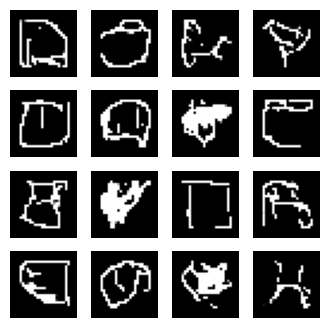

In [30]:
train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Restore the latest checkpoint.

## Create a GIF


In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

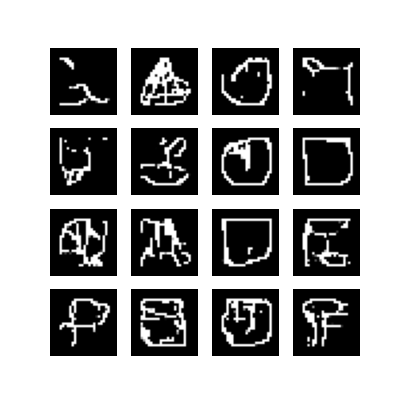

In [26]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [35]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-35-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-35-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



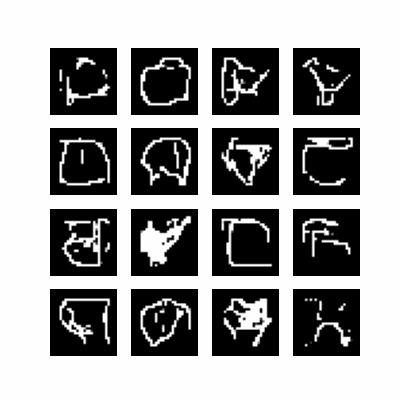

In [34]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

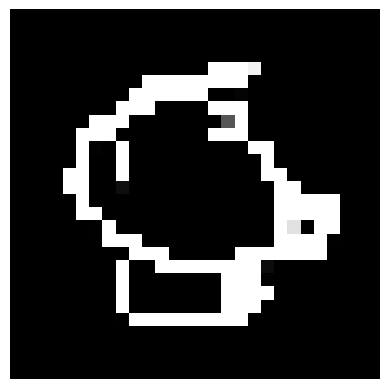

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise (latent vector)
latent_dim = 100  # Same as used in training
random_noise = tf.random.normal([1, latent_dim])

# Generate an image
generated_image = generator(random_noise, training=False)

# Rescale pixel values from [-1, 1] to [0, 1]
generated_image = (generated_image + 1) / 2.0

# Display the image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")  # Use cmap="gray" for grayscale
plt.axis("off")
plt.show()


# Svae the model and use Later

To save generator

In [49]:
# Save the generator model
generator.save("dcgan_generator_doodleMega.keras")


In [50]:
from tensorflow.keras.models import load_model

# Load the generator model
generatorLoaded = load_model("dcgan_generator_doodleMega.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


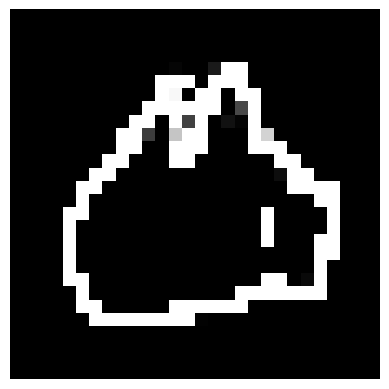

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise
noise = np.random.normal(0, 1, (1, 100))  # Adjust size to match your latent space

# Generate image
generated_image = generatorLoaded.predict(noise)

# Display image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")  # Use cmap="gray" for grayscale
plt.axis("off")
plt.show()
